# Supervised learning - Regression
Goal of the excercise is to learn how to use Scikit-learn library for a regression tasks employing various regression models and moreover evaluate the performance of the proposed models.

In [246]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [334]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, rmse, mape = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}], index=[0])

In [335]:
def plot_results(y_test, y_pred):
    df_res = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_res_s = df_res.stack().reset_index(name='value').rename({'instant': 'idx', 'level_1': 'variable'}, axis=1)
    return sns.lineplot(data = df_res_s, x='idx', y='value', hue='variable')

## Dataset
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

### Metadata:
- "timestamp" - timestamp field for grouping the data
- "cnt" - the count of a new bike shares
- "t1" - real temperature in C
- "t2" - temperature in C "feels like"
- "hum" - humidity in percentage
- "windspeed" - wind speed in km/h
- "weathercode" - category of the weather
- "isholiday" - boolean field - 1 holiday / 0 non holiday
- "isweekend" - boolean field - 1 if the day is weekend
- "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

- "weathe_code" category description:
    - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
    - 2 = scattered clouds / few clouds 
    - 3 = Broken clouds 
    - 4 = Cloudy 
    - 7 = Rain/ light Rain shower/ Light rain 
    - 10 = rain with thunderstorm 
    - 26 = snowfall 
    - 94 = Freezing Fog

In [336]:
df = pd.read_csv('bike.csv', index_col=0, parse_dates=['dteday'])
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [337]:
df.dtypes

dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

In [338]:
df['day_of_year'] = df.dteday.dt.dayofyear

<AxesSubplot:xlabel='instant'>

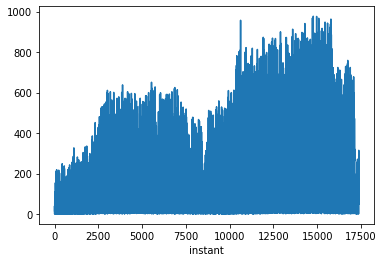

In [339]:
df.cnt.plot()

<AxesSubplot:xlabel='dteday'>

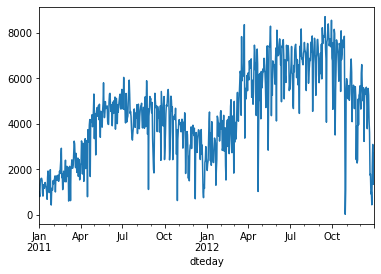

In [340]:
df.groupby('dteday').cnt.sum().plot()

## Cyclical features encoding

https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca



In [341]:
# We normalize x values to match with the 0-2π cycle
df['month_norm'] = 2 * math.pi * df['mnth'] / df['mnth'].max()
df['month_cos'] = np.cos(df['month_norm'])
df['month_sin'] = np.sin(df['month_norm'])
df.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day_of_year,month_norm,month_cos,month_sin
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,1.737900e+04,1.737900e+04
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,183.738017,3.423171,-6.459681e-03,-5.533791e-03
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,105.175185,1.800539,7.087640e-01,7.054352e-01
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.523599,-1.000000e+00,-1.000000e+00
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,93.000000,2.094395,-8.660254e-01,-8.660254e-01
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,184.000000,3.665191,-1.836970e-16,-2.449294e-16
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,275.000000,5.235988,8.660254e-01,5.000000e-01
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,366.000000,6.283185,1.000000e+00,1.000000e+00


## How to evaluate our dataset?

In [390]:
X, y = df.loc[:, ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'month_cos', 'month_sin']], df.loc[:, 'cnt']
X.shape, y.shape

((17379, 15), (17379,))

In [391]:
X

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day_of_year,month_cos,month_sin
instant,,,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,1,0.866025,5.000000e-01
2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,1,0.866025,5.000000e-01
3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,1,0.866025,5.000000e-01
4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,1,0.866025,5.000000e-01
5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,366,1.000000,-2.449294e-16
17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,366,1.000000,-2.449294e-16
17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,366,1.000000,-2.449294e-16


In [392]:
X_train, X_test = X.iloc[:14000, :], X.iloc[14000:, :]
y_train, y_test = y.iloc[:14000], y.iloc[14000:]

In [393]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,136.435576,33606.494071,183.320741,351.485559


<AxesSubplot:xlabel='idx', ylabel='value'>

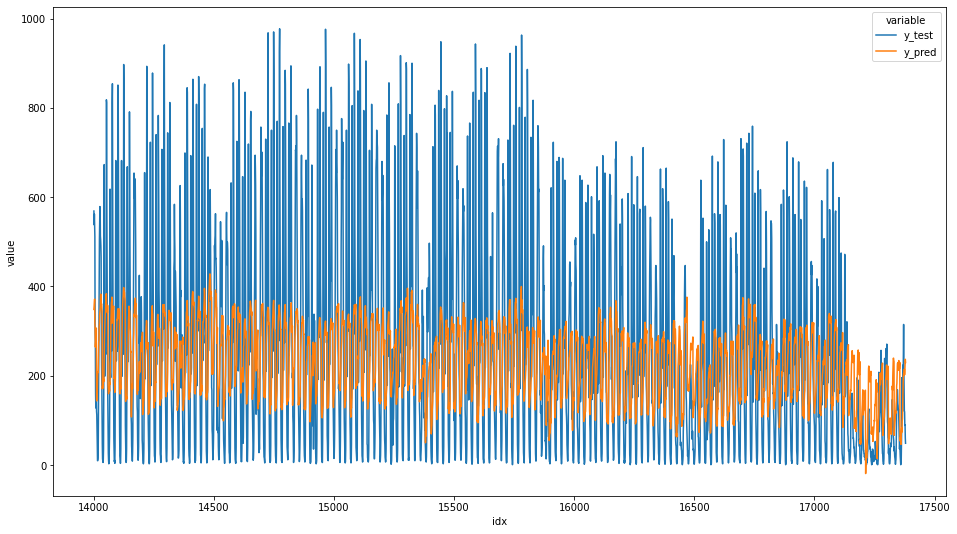

In [394]:
fig = plt.figure(figsize=(16, 9))
plot_results(y_test, y_pred)

### Can we use crossvalidation for evaluation?

- Dle mého normálně jde využít cross validation technika pro vyhodnocení algoritmu. 
- Nic se nemění na přístupu, který cross validace poskytuje, k porovnání mezi testovacími a trénovacími daty.

# Stackoverflow

I would like to add here, that this negative error is also helpful in finding best algorithm when you are comparing multiple algorithms through GridSearchCV().

This is because after training, GridSearchCV() ranks all the algorithms(estimators) and tells you which one is the best. Now when you use an error function, estimator with higher score will be ranked higher by sklearn, which is not true in the case of MAE (along with MSE and a few others).

To deal with this, the library flips the sign of error, so the highest MAE will be ranked lowest and vice versa.

So to answer your question: -2.6 is better than -3.0 because the actual MAE is 2.6 and 3.0 respectively.

## Regression (2p)

- Use at leats 3 different regression models from Sklearn library.
- Try different paramters, compare scores a find the best model configuration
- Does cyclical feature encoding help?

In [395]:
from sklearn.model_selection import GridSearchCV

In [396]:
def get_dataframe_from_grid_search(grid_search, data, model):
    mean_results = grid_search.cv_results_['mean_test_score']
    params = np.array(grid_search.cv_results_['params'])
    
    index = {}
    metrics = []
    Y_pred = []
    Y_test = []
    
    X_train, X_test, y_train, y_test = data
    
    for p in params:
        
        instance = model()
        instance.fit(X_train, y_train)
        y_pred = instance.predict(X_test)
        met = compute_metrics_raw(y_test, y_pred)
        metrics.append(met)
        Y_pred.append(y_pred)
        Y_test.append(y_test)
        
        #run configuraration on test data! and save predction! for data plot -> [y_test, y_pred]!
        for k, v in p.items():
            value = index.get(k, [])
            value.append(v)
            index[k] = value 
    
    results = pd.DataFrame.from_dict(index)
    results['Score'] = mean_results
    results['Metrics'] = metrics
    results['Y_pred'] = Y_pred
    results['Y_test'] = Y_test
    return results

In [397]:
linearRegression_Params = {}

In [398]:
decisionTreeRegressor_Params = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [None, 10, 50],
    'min_samples_split': [2, 5, 10]    
}

In [399]:
elasticNet_Params = {
    'alpha': [1, 2, 5, 10],
    'l1_ratio': [0.5, 1],
    'selection': ['cyclic', 'random']
}

In [400]:
params = [linearRegression_Params, decisionTreeRegressor_Params, elasticNet_Params]

In [401]:
models = [LinearRegression(), DecisionTreeRegressor(), ElasticNet()]

In [402]:
refs = [LinearRegression, DecisionTreeRegressor, ElasticNet]

In [403]:
%%time

results = {}

for i in range(len(models)):
    
    print(f'Experiments for model {i}')
    
    current_model = models[i]
    current_params = params[i]
    current_ref = refs[i]
    
    grid_search = GridSearchCV(estimator = current_model, param_grid = current_params, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train.ravel())
    results[i] = get_dataframe_from_grid_search(grid_search, (X_train, X_test, y_train, y_test), current_ref)

Experiments for model 0
Experiments for model 1
Experiments for model 2
Wall time: 3min 16s


In [404]:
results;

# S cyklickými proměnými

## Linear Regression 

In [405]:
df_res = results[0].sort_values(by='Score', ascending=False)
df_res.head()

,Score,Metrics,Y_pred,Y_test
0,-19229.013544,MAE MSE RMSE ...,"[348.667269103728, 354.517666947399, 364.48873...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

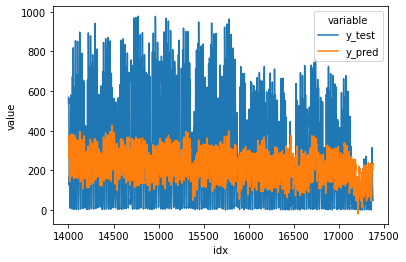

In [406]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

## Decision Tree Regressor

In [407]:
df_res = results[1].sort_values(by='Score', ascending=False)
df_res.head()

,criterion,max_depth,min_samples_split,Score,Metrics,Y_pred,Y_test
11,absolute_error,NaN,10,-7629.399071,MAE MSE RMSE MAP...,"[483.0, 483.0, 522.0, 522.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...
2,squared_error,NaN,10,-8068.820769,MAE MSE RMSE MAP...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...
13,absolute_error,10.0,5,-8533.602125,MAE MSE RMSE MAP...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...
17,absolute_error,50.0,10,-8542.443125,MAE MSE RMSE MAPE...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...
12,absolute_error,10.0,2,-8653.356732,MAE MSE RMSE MAPE...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

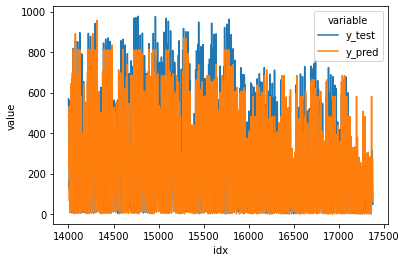

In [408]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

## Elastic Net 

In [409]:
df_res = results[2].sort_values(by='Score', ascending=False)
df_res.head()

,alpha,l1_ratio,selection,Score,Metrics,Y_pred,Y_test
2,1,1.0,cyclic,-18517.345577,MAE MSE RMSE ...,"[248.88644025440044, 258.2621081085828, 267.88...",instant 14001 569 14002 538 14003 562...
3,1,1.0,random,-18518.158415,MAE MSE RMSE ...,"[248.88644025440044, 258.2621081085828, 267.88...",instant 14001 569 14002 538 14003 562...
7,2,1.0,random,-18654.721768,MAE MSE RMSE ...,"[248.88644025440044, 258.2621081085828, 267.88...",instant 14001 569 14002 538 14003 562...
6,2,1.0,cyclic,-18655.173682,MAE MSE RMSE ...,"[248.88644025440044, 258.2621081085828, 267.88...",instant 14001 569 14002 538 14003 562...
11,5,1.0,random,-20430.477486,MAE MSE RMSE ...,"[248.88644025440044, 258.2621081085828, 267.88...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

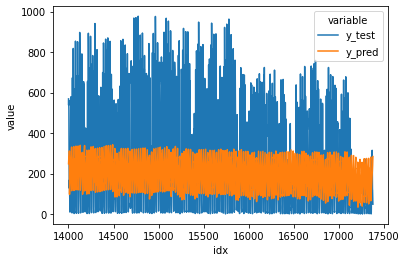

In [410]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

# Bez proměných

In [411]:
X, y = df.loc[:, ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'month_norm']], df.loc[:, 'cnt']

In [412]:
X

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,day_of_year,month_norm
instant,,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,1,0.523599
2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,1,0.523599
3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,1,0.523599
4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,1,0.523599
5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,0.523599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,366,6.283185
17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,366,6.283185
17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,366,6.283185


In [365]:
X_train, X_test = X.iloc[:14000, :], X.iloc[14000:, :]
y_train, y_test = y.iloc[:14000], y.iloc[14000:]

In [383]:
%%time

results_without = {}

for i in range(len(models)):
    
    print(f'Experiments for model {i}')
    
    current_model = models[i]
    current_params = params[i]
    current_ref = refs[i]
    
    grid_search = GridSearchCV(estimator = current_model, param_grid = current_params, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train.ravel())
    results_without[i] = get_dataframe_from_grid_search(grid_search, (X_train, X_test, y_train, y_test), current_ref)

Experiments for model 0
Experiments for model 1
Experiments for model 2
Wall time: 3min 1s


## Linear Regression 

In [384]:
df_res = results_without[0].sort_values(by='Score', ascending=False)
df_res.head()

,Score,Metrics,Y_pred,Y_test
0,-19313.13291,MAE MSE RMSE M...,"[360.16080531906067, 365.36783656906067, 373.8...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

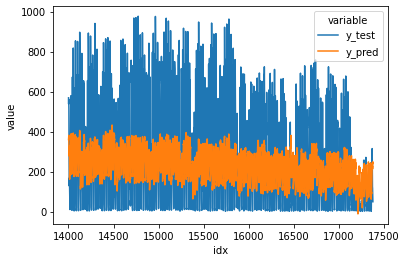

In [385]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

## Decision Tree Regressor

In [386]:
df_res = results_without[1].sort_values(by='Score', ascending=False)
df_res.head()

,criterion,max_depth,min_samples_split,Score,Metrics,Y_pred,Y_test
17,absolute_error,50.0,10,-7975.083929,MAE MSE RMSE MAP...,"[483.0, 483.0, 522.0, 522.0, 462.0, 229.0, 431...",instant 14001 569 14002 538 14003 562...
11,absolute_error,NaN,10,-8057.990429,MAE MSE RMSE MAP...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 338...",instant 14001 569 14002 538 14003 562...
8,squared_error,50.0,10,-8073.413600,MAE MSE RMSE MAP...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 431...",instant 14001 569 14002 538 14003 562...
2,squared_error,NaN,10,-8156.352232,MAE MSE RMSE MAPE...,"[483.0, 483.0, 522.0, 522.0, 462.0, 229.0, 431...",instant 14001 569 14002 538 14003 562...
14,absolute_error,10.0,10,-8629.632232,MAE MSE RMSE MAP...,"[483.0, 483.0, 546.0, 546.0, 462.0, 229.0, 431...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

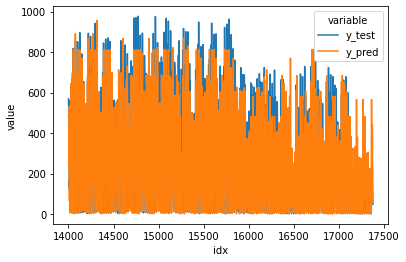

In [387]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

## Elastic Net 

In [388]:
df_res = results_without[2].sort_values(by='Score', ascending=False)
df_res.head()

,alpha,l1_ratio,selection,Score,Metrics,Y_pred,Y_test
3,1,1.0,random,-18202.147391,MAE MSE RMSE ...,"[241.24599383953, 250.57384790258033, 260.0756...",instant 14001 569 14002 538 14003 562...
2,1,1.0,cyclic,-18202.465878,MAE MSE RMSE ...,"[241.24599383953, 250.57384790258033, 260.0756...",instant 14001 569 14002 538 14003 562...
7,2,1.0,random,-18240.234133,MAE MSE RMSE ...,"[241.24599383953, 250.57384790258033, 260.0756...",instant 14001 569 14002 538 14003 562...
6,2,1.0,cyclic,-18241.317145,MAE MSE RMSE ...,"[241.24599383953, 250.57384790258033, 260.0756...",instant 14001 569 14002 538 14003 562...
10,5,1.0,cyclic,-21115.085159,MAE MSE RMSE ...,"[241.24599383953, 250.57384790258033, 260.0756...",instant 14001 569 14002 538 14003 562...


<AxesSubplot:xlabel='idx', ylabel='value'>

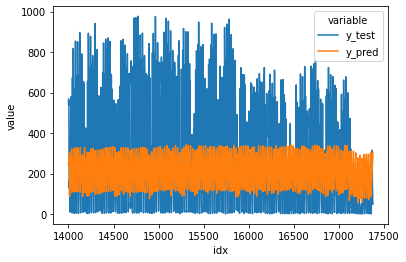

In [389]:
plot_results(df_res['Y_test'].values[0], df_res['Y_pred'].values[0])

# Does cyclical feature encoding help?

- Jde o zlepšení vzdálenosti mezi cyklickými proměnými. Například měsíce. Prosinec [12], leden[1]. Vzdálenost je **větší než je zdrávo**. Reálně jsou vzdálené totiž jen o **1!**
- Nevýhodou je tranfomování 1 featury do dvou, a tak vzniká problém například při splitu u descision trees. Jedna featura je teď zakodována do 2.
- V jednom případě byly využity pouze cyklické, v druhém pouze normalizované. Jak lze vidět nedošlo k markatnímu zlepšení, ale i tak cyklické mají kapku lepší výsledky.
- Zajímavosti je, že 2 bod nebyl potvrzen.

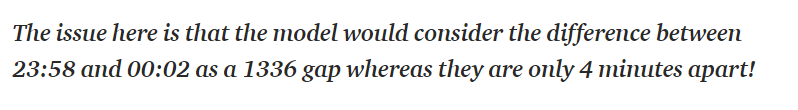